In [1]:
# Setup
import pandas as pd
import numpy as np
import os
import git
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/opt/conda/envs/posedemo/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load keypoints

In [2]:
subjects = np.load("{}/preprocessing/poseformer/subjects.npy".format(homedir))
keypoints2d = np.load("{}/preprocessing/poseformer/joints_2d_padded.npy".format(homedir))
print(keypoints2d.shape)

(384, 1511, 17, 2)


In [3]:
num_samples = keypoints2d.shape[0]
keypoints2d = keypoints2d.reshape((num_samples, -1))      # Flatten frame, joint and coordinates
df_kp2d = pd.DataFrame(keypoints2d)
df_kp2d.insert(0, 'subjectid', subjects)

df_kp2d

,subjectid,0,1,2,3,4,5,6,7,8,...,51364,51365,51366,51367,51368,51369,51370,51371,51372,51373
0,kEC7G8DP,315.685852,753.182617,274.055603,758.386353,378.131226,831.239319,326.093414,1018.575378,357.316101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GjPHiGli,456.260345,829.245667,393.725159,844.879456,581.330688,938.682251,534.429321,1235.724365,518.795532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,RFibHPt7,112.074158,559.071594,126.040131,568.382263,247.078568,605.624817,247.078568,754.595215,98.108185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,gO7Cpt1X,184.985413,261.598724,169.771530,257.795258,136.808105,283.151733,152.021988,333.864685,200.199295,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,xEIsrkiR,260.938232,641.753784,168.722412,641.753784,298.909454,771.940796,179.571335,880.429993,353.154053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,VID_20230506_175810340,558.194092,756.626953,447.130249,781.307861,521.172852,1250.244263,521.172852,1447.691162,669.257996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,8elUiJYv,535.904724,1174.302490,487.117706,1182.433594,600.954102,1361.319336,584.691772,1670.303955,584.691772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381,PXL_20230505_234002299,412.282166,884.938721,348.439545,906.219543,348.439545,1204.151611,433.563019,1374.398560,476.124756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
382,q8FyLMSn,251.466553,714.515015,204.084229,734.821716,244.697662,843.124207,258.235474,1046.191284,298.848877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load Survey Data (labels)

In [4]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [5]:
# join the dataframes by subjectId - precalculated features only
df_join = df_kp2d.set_index('subjectid').join(df_survey.set_index('subjectid')).astype('float32')
df_join

,0,1,2,3,4,5,6,7,8,9,...,51365,51366,51367,51368,51369,51370,51371,51372,51373,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,315.685852,753.182617,274.055603,758.386353,378.131226,831.239319,326.093414,1018.575378,357.316101,747.978821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GjPHiGli,456.260345,829.245667,393.725159,844.879456,581.330688,938.682251,534.429321,1235.724365,518.795532,813.611877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RFibHPt7,112.074158,559.071594,126.040131,568.382263,247.078568,605.624817,247.078568,754.595215,98.108185,549.760925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gO7Cpt1X,184.985413,261.598724,169.771530,257.795258,136.808105,283.151733,152.021988,333.864685,200.199295,265.402191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xEIsrkiR,260.938232,641.753784,168.722412,641.753784,298.909454,771.940796,179.571335,880.429993,353.154053,641.753784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,558.194092,756.626953,447.130249,781.307861,521.172852,1250.244263,521.172852,1447.691162,669.257996,731.946106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8elUiJYv,535.904724,1174.302490,487.117706,1182.433594,600.954102,1361.319336,584.691772,1670.303955,584.691772,1166.171265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PXL_20230505_234002299,412.282166,884.938721,348.439545,906.219543,348.439545,1204.151611,433.563019,1374.398560,476.124756,863.657837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [6]:
# all videos from the new clinical trial have OA=1 
df_join = df_join.fillna(value={'OA_check': 1})
df_join

,0,1,2,3,4,5,6,7,8,9,...,51365,51366,51367,51368,51369,51370,51371,51372,51373,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,315.685852,753.182617,274.055603,758.386353,378.131226,831.239319,326.093414,1018.575378,357.316101,747.978821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GjPHiGli,456.260345,829.245667,393.725159,844.879456,581.330688,938.682251,534.429321,1235.724365,518.795532,813.611877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RFibHPt7,112.074158,559.071594,126.040131,568.382263,247.078568,605.624817,247.078568,754.595215,98.108185,549.760925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gO7Cpt1X,184.985413,261.598724,169.771530,257.795258,136.808105,283.151733,152.021988,333.864685,200.199295,265.402191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xEIsrkiR,260.938232,641.753784,168.722412,641.753784,298.909454,771.940796,179.571335,880.429993,353.154053,641.753784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,558.194092,756.626953,447.130249,781.307861,521.172852,1250.244263,521.172852,1447.691162,669.257996,731.946106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8elUiJYv,535.904724,1174.302490,487.117706,1182.433594,600.954102,1361.319336,584.691772,1670.303955,584.691772,1166.171265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PXL_20230505_234002299,412.282166,884.938721,348.439545,906.219543,348.439545,1204.151611,433.563019,1374.398560,476.124756,863.657837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Data validation 

In [7]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [8]:
# 384 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [9]:
# Check for number of OA positive and number of samples in the dataset
# Total - 78% OA=0, 22% OA=1
print(df_join.iloc[:,-1].count())  # 384
print(df_join.iloc[:,-1].sum())    # 83
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 78% training accuracy
print(train_data.iloc[:,-1].count())  # 306
print(train_data.iloc[:,-1].sum())    # 67

# Validation set - This implies that if the model always predicts 0, it would have 79% val accuracy
print(val_data.iloc[:,-1].count())  # 39
print(val_data.iloc[:,-1].sum())    # 8

# Test set - This implies that if the model always predicts 0, it would have 79% test accuracy
print(test_data.iloc[:,-1].count())  # 39
print(test_data.iloc[:,-1].sum())    # 8

384
83.0
306
67.0
39
8.0
39
8.0


#### Normalization

In [10]:
# compute mean and std of the features 
means = []
stds = []
for column in train_data.iloc[:,:-1]: # only use training set, and exclude last column, which has labels
    column_np = train_data[column].to_numpy()
    means.append(np.mean(column_np))
    stds.append(np.std(column_np) + 0.00001) # for numerical stability
    
# apply normalization
def transform(feature): 
    return (feature - means) / stds

#### Create dataloaders

In [11]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

In [12]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 51374]) torch.Size([64])
tensor([[ 0.5330,  0.0337,  0.5317,  ..., -0.0573, -0.0573, -0.0573],
        [ 0.0350,  1.0372, -0.2976,  ..., -0.0573, -0.0573, -0.0573],
        [ 1.2692,  0.6129,  0.9933,  ..., -0.0573, -0.0573, -0.0573],
        ...,
        [ 1.7034,  0.3587,  1.3291,  ..., -0.0573, -0.0573, -0.0573],
        [-0.1485, -0.0441,  0.1436,  ..., -0.0573, -0.0573, -0.0573],
        [-0.0130, -0.2572, -0.0771,  ..., -0.0573, -0.0573, -0.0573]],
       dtype=torch.float64) tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 1., 0., 0.])


#### Create dataloaders with upsampling 

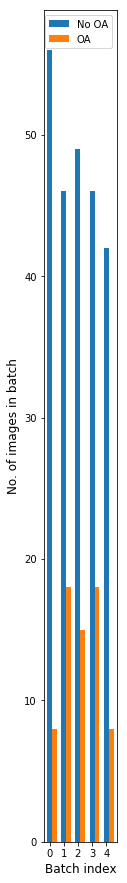

Avg Proportion of No OA per batch: 4.779999999999999
Avg Proportion of OA per batch: 1.3399999999999999
Num. unique images seen: 306/306


In [13]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

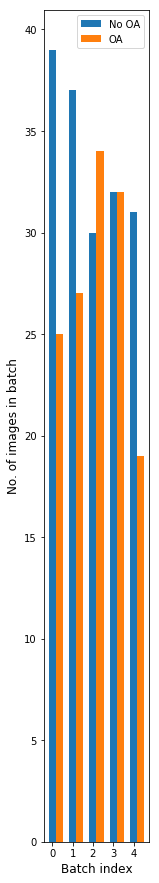

Avg Proportion of No OA per batch: 3.3800000000000003
Avg Proportion of OA per batch: 2.74
Num. unique images seen: 182/306


In [14]:
train = CustomDataset(dataframe=train_data, transform=transform)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with normalized inputs, no oversampling

In [15]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 51374
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

Epoch 0, loss = 1.0825, train_acc = 77.4510, val_acc = 82.0513, train_pos = 8.4967, val_pos = 2.5641
Epoch 1, loss = 0.8968, train_acc = 81.0458, val_acc = 89.7436, train_pos = 6.8627, val_pos = 15.3846
Epoch 2, loss = 0.4863, train_acc = 77.1242, val_acc = 84.6154, train_pos = 24.5098, val_pos = 10.2564
Epoch 3, loss = 0.3365, train_acc = 79.7386, val_acc = 84.6154, train_pos = 4.9020, val_pos = 5.1282
Epoch 4, loss = 0.3733, train_acc = 83.0065, val_acc = 76.9231, train_pos = 4.9020, val_pos = 12.8205
Epoch 5, loss = 0.3949, train_acc = 82.3529, val_acc = 87.1795, train_pos = 10.1307, val_pos = 12.8205
Epoch 6, loss = 0.5545, train_acc = 81.3725, val_acc = 84.6154, train_pos = 11.7647, val_pos = 5.1282
Epoch 7, loss = 0.5218, train_acc = 83.0065, val_acc = 84.6154, train_pos = 4.9020, val_pos = 5.1282
Epoch 8, loss = 0.2946, train_acc = 82.6797, val_acc = 84.6154, train_pos = 8.4967, val_pos = 10.2564
Epoch 9, loss = 0.3108, train_acc = 84.6405, val_acc = 89.7436, train_pos = 9.1503,

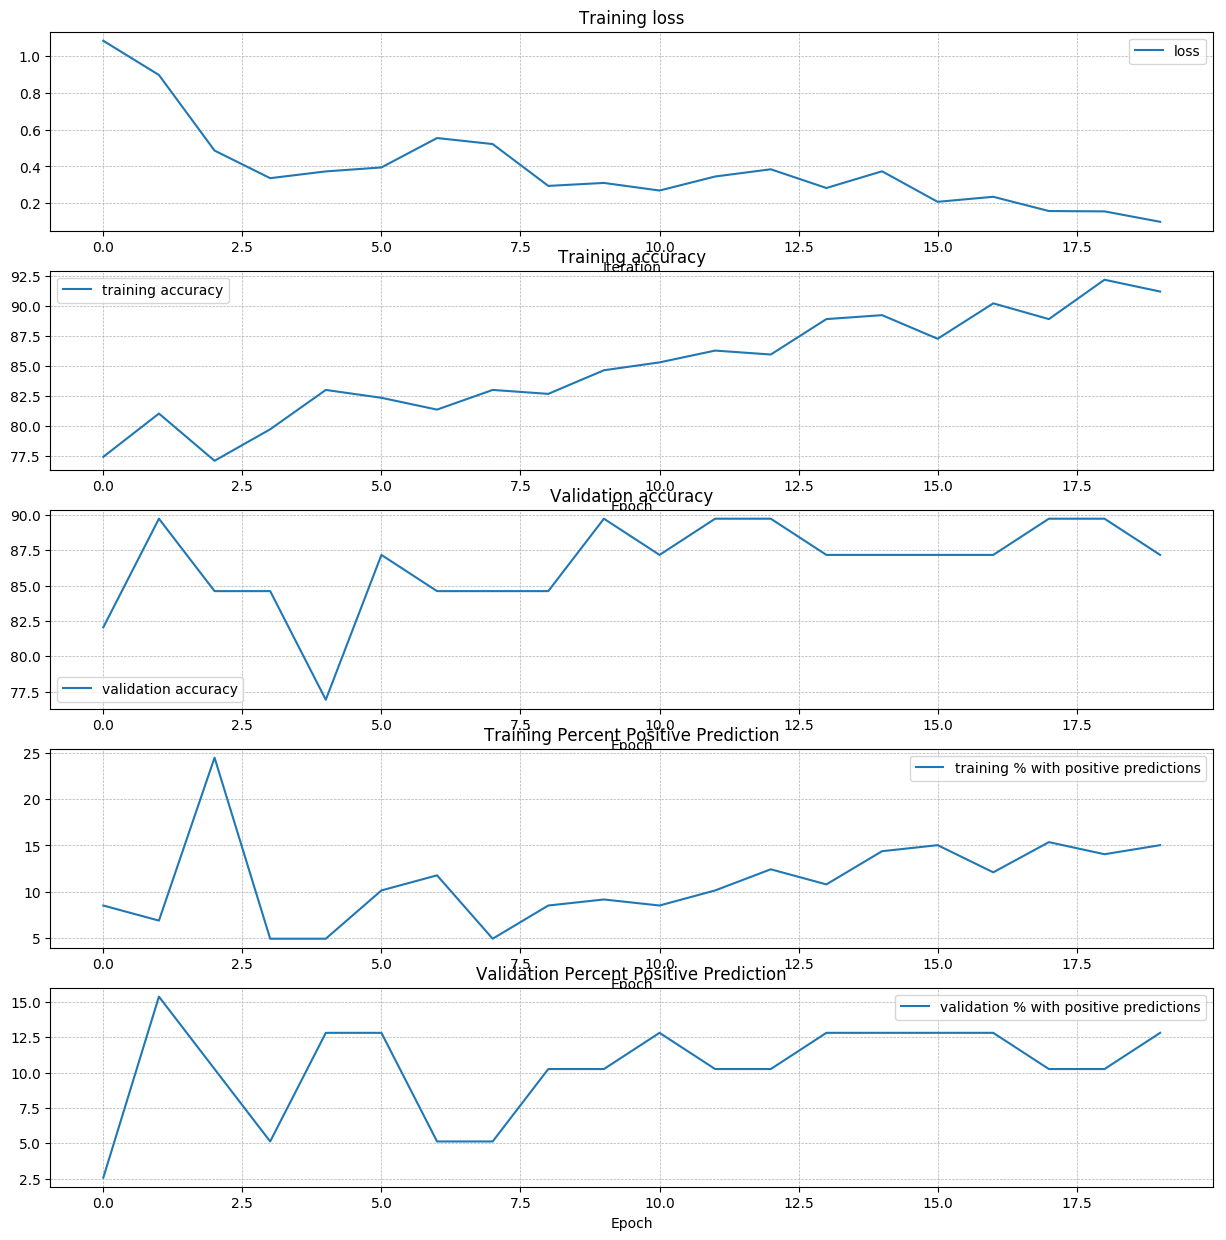

In [16]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs on oversampled training set

In [17]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 51374
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

Epoch 0, loss = 0.9926, train_acc = 59.4771, val_acc = 82.0513, train_pos = 32.3529, val_pos = 23.0769
Epoch 1, loss = 0.7702, train_acc = 69.6078, val_acc = 84.6154, train_pos = 39.8693, val_pos = 20.5128
Epoch 2, loss = 0.4190, train_acc = 74.1830, val_acc = 74.3590, train_pos = 43.7908, val_pos = 30.7692
Epoch 3, loss = 0.6361, train_acc = 68.6275, val_acc = 79.4872, train_pos = 41.1765, val_pos = 25.6410
Epoch 4, loss = 0.5280, train_acc = 75.1634, val_acc = 84.6154, train_pos = 42.4837, val_pos = 10.2564
Epoch 5, loss = 0.3764, train_acc = 77.4510, val_acc = 76.9231, train_pos = 39.2157, val_pos = 28.2051
Epoch 6, loss = 0.5258, train_acc = 77.4510, val_acc = 84.6154, train_pos = 54.9020, val_pos = 10.2564
Epoch 7, loss = 0.4009, train_acc = 78.7582, val_acc = 74.3590, train_pos = 34.3137, val_pos = 25.6410
Epoch 8, loss = 0.4593, train_acc = 86.9281, val_acc = 87.1795, train_pos = 50.3268, val_pos = 17.9487
Epoch 9, loss = 0.2605, train_acc = 88.5621, val_acc = 84.6154, train_pos

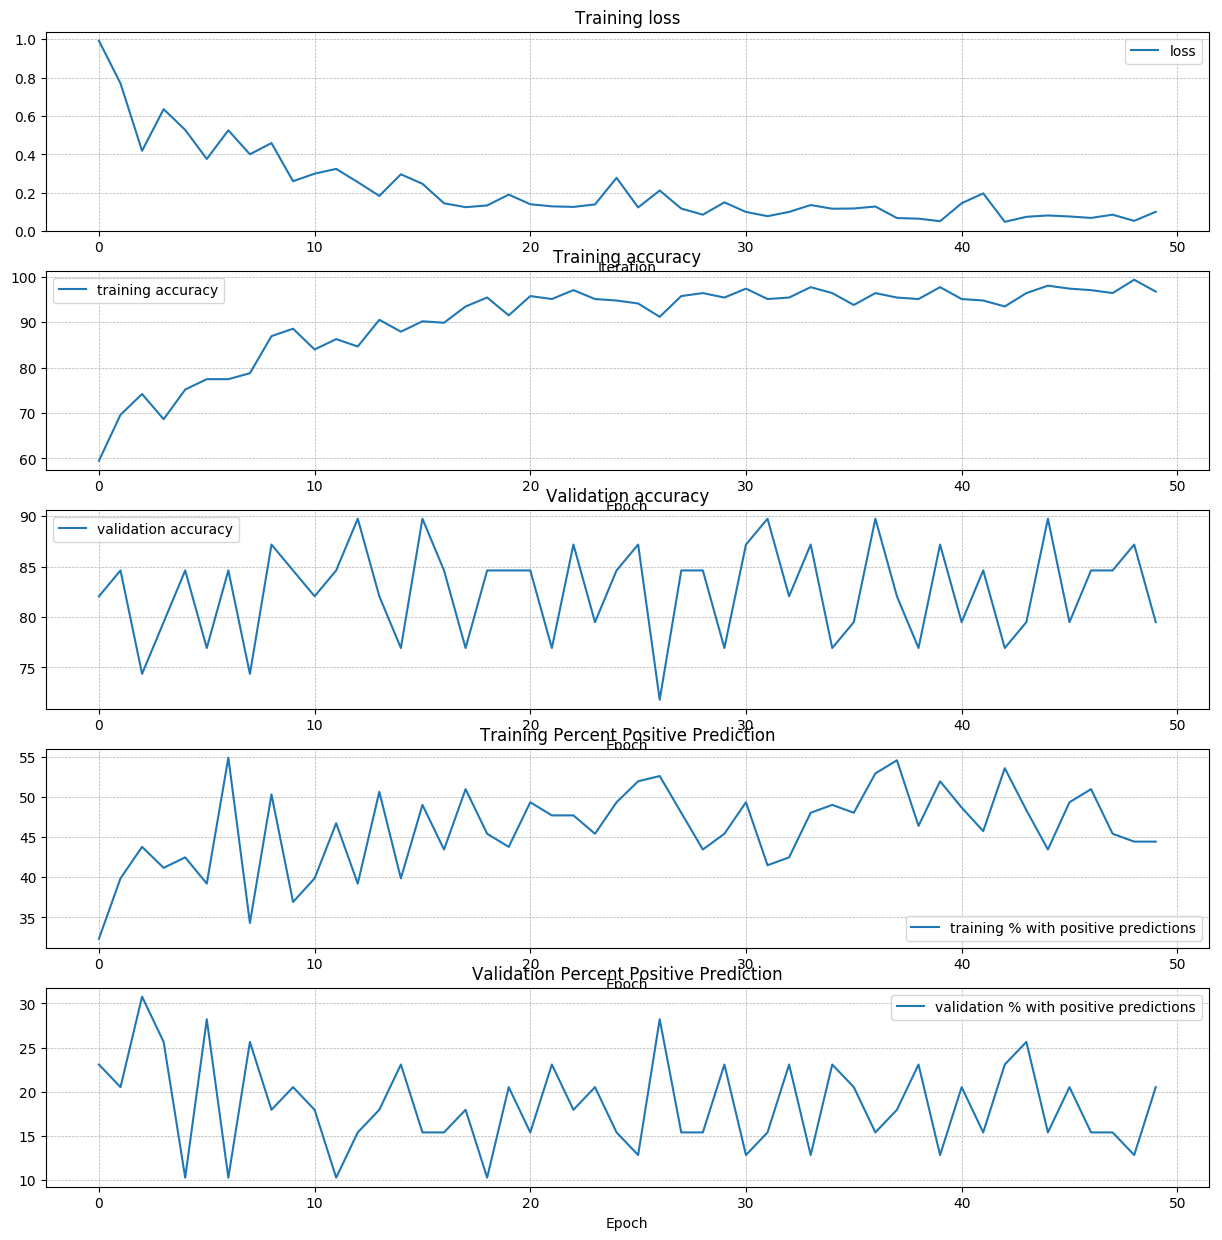

In [18]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs, alternative oversampling 

In [19]:
# oversample the train/val data by increasing number of OA=1 and increasing overall dataset size
#train_val_data = pd.concat([train_data, val_data], axis=0)
index_0 = train_data.index[train_data['OA_check'] == 0.0].tolist()
class_0 = train_data.loc[index_0]
index_1 = train_data.index[train_data['OA_check'] == 1.0].tolist()
class_1 = train_data.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_over = train_over.sample(frac = 1)

NUM_TRAIN_OS = len(train_over)

train = CustomDataset(dataframe=train_over, transform=transform)
loader_train_os2 = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_OS)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 51374
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os2, loader_val, epochs=50)

Epoch 0, loss = 1.0286, train_acc = 62.7615, val_acc = 84.6154, train_pos = 31.1715, val_pos = 15.3846
Epoch 1, loss = 0.8397, train_acc = 74.8954, val_acc = 82.0513, train_pos = 43.3054, val_pos = 23.0769
Epoch 2, loss = 0.4867, train_acc = 70.7113, val_acc = 76.9231, train_pos = 26.1506, val_pos = 17.9487
Epoch 3, loss = 0.4037, train_acc = 76.1506, val_acc = 89.7436, train_pos = 42.4686, val_pos = 15.3846
Epoch 4, loss = 0.4289, train_acc = 78.8703, val_acc = 87.1795, train_pos = 39.7490, val_pos = 12.8205
Epoch 5, loss = 0.7085, train_acc = 80.7531, val_acc = 89.7436, train_pos = 43.3054, val_pos = 15.3846
Epoch 6, loss = 0.2694, train_acc = 84.7280, val_acc = 84.6154, train_pos = 41.4226, val_pos = 15.3846
Epoch 7, loss = 0.2388, train_acc = 87.2385, val_acc = 89.7436, train_pos = 42.2594, val_pos = 15.3846
Epoch 8, loss = 0.1712, train_acc = 88.9121, val_acc = 89.7436, train_pos = 43.0962, val_pos = 15.3846
Epoch 9, loss = 0.2630, train_acc = 89.9582, val_acc = 87.1795, train_pos

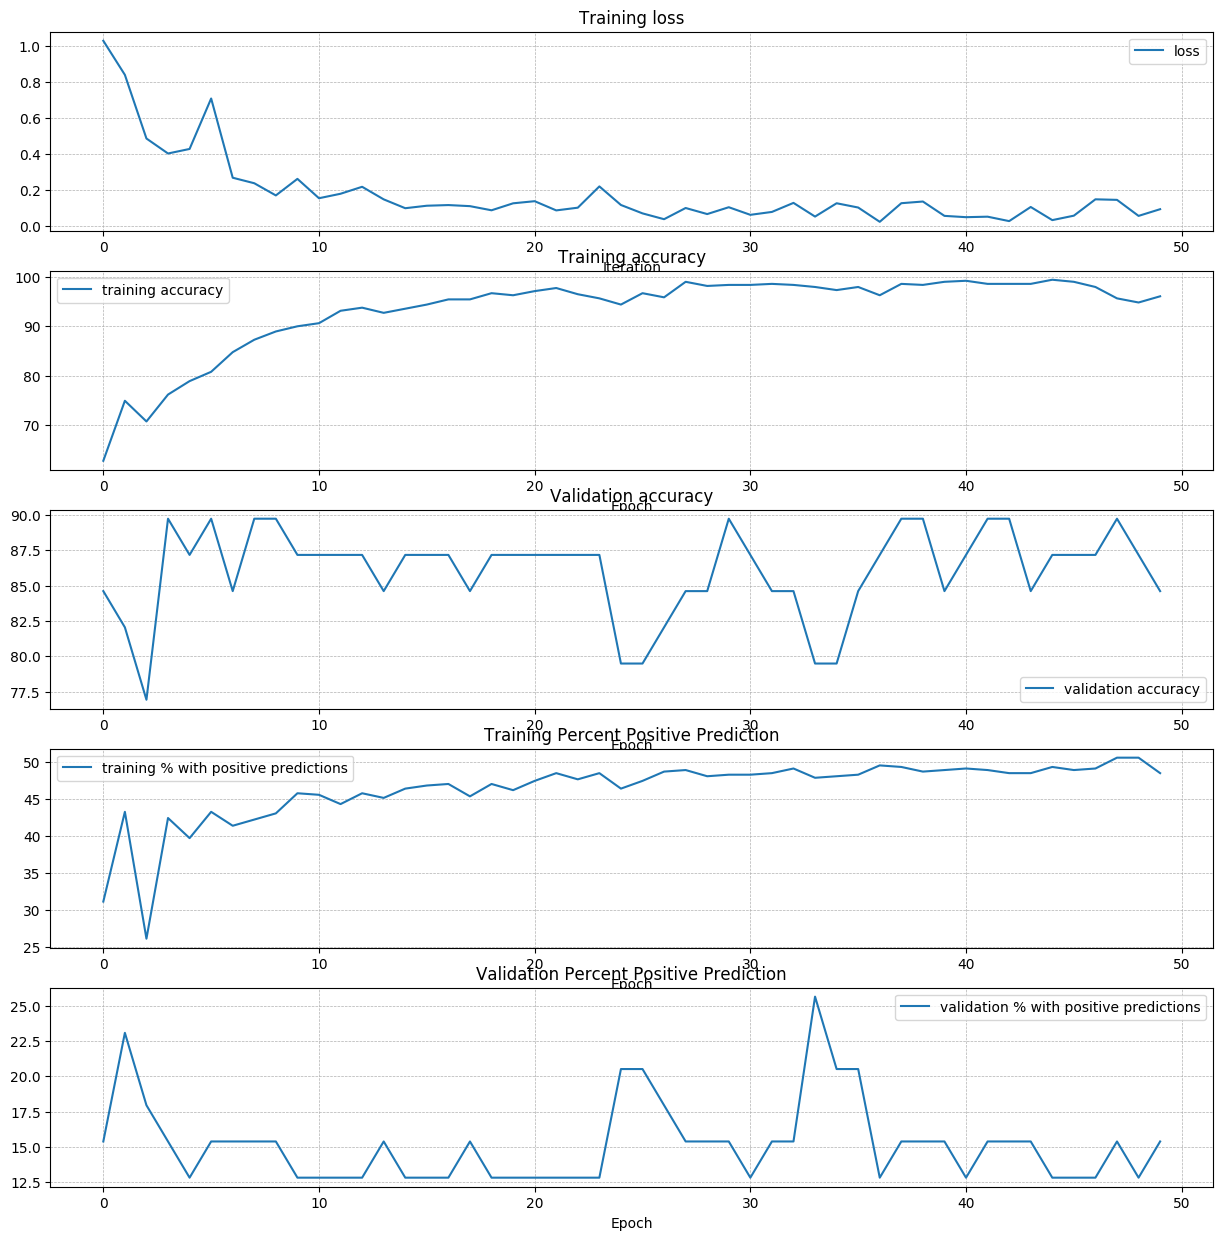

In [20]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling

In [21]:
train = CustomDataset(dataframe=train_data)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data)
loader_test = DataLoader(test, batch_size=64)

In [22]:
input_size = 51374
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50)

Epoch 0, loss = 346.2326, train_acc = 71.2418, val_acc = 79.4872, train_pos = 17.3203, val_pos = 15.3846
Epoch 1, loss = 100.3594, train_acc = 62.7451, val_acc = 79.4872, train_pos = 40.8497, val_pos = 15.3846
Epoch 2, loss = 113.3499, train_acc = 78.4314, val_acc = 82.0513, train_pos = 8.8235, val_pos = 17.9487
Epoch 3, loss = 113.8046, train_acc = 56.8627, val_acc = 82.0513, train_pos = 43.4641, val_pos = 2.5641
Epoch 4, loss = 30.1861, train_acc = 79.7386, val_acc = 33.3333, train_pos = 12.7451, val_pos = 87.1795
Epoch 5, loss = 41.4056, train_acc = 68.3007, val_acc = 79.4872, train_pos = 37.2549, val_pos = 0.0000
Epoch 6, loss = 52.1717, train_acc = 75.1634, val_acc = 51.2821, train_pos = 15.3595, val_pos = 69.2308
Epoch 7, loss = 74.8056, train_acc = 71.5686, val_acc = 87.1795, train_pos = 24.1830, val_pos = 7.6923
Epoch 8, loss = 18.4463, train_acc = 71.2418, val_acc = 79.4872, train_pos = 33.0065, val_pos = 0.0000
Epoch 9, loss = 9.2600, train_acc = 71.2418, val_acc = 82.0513, t

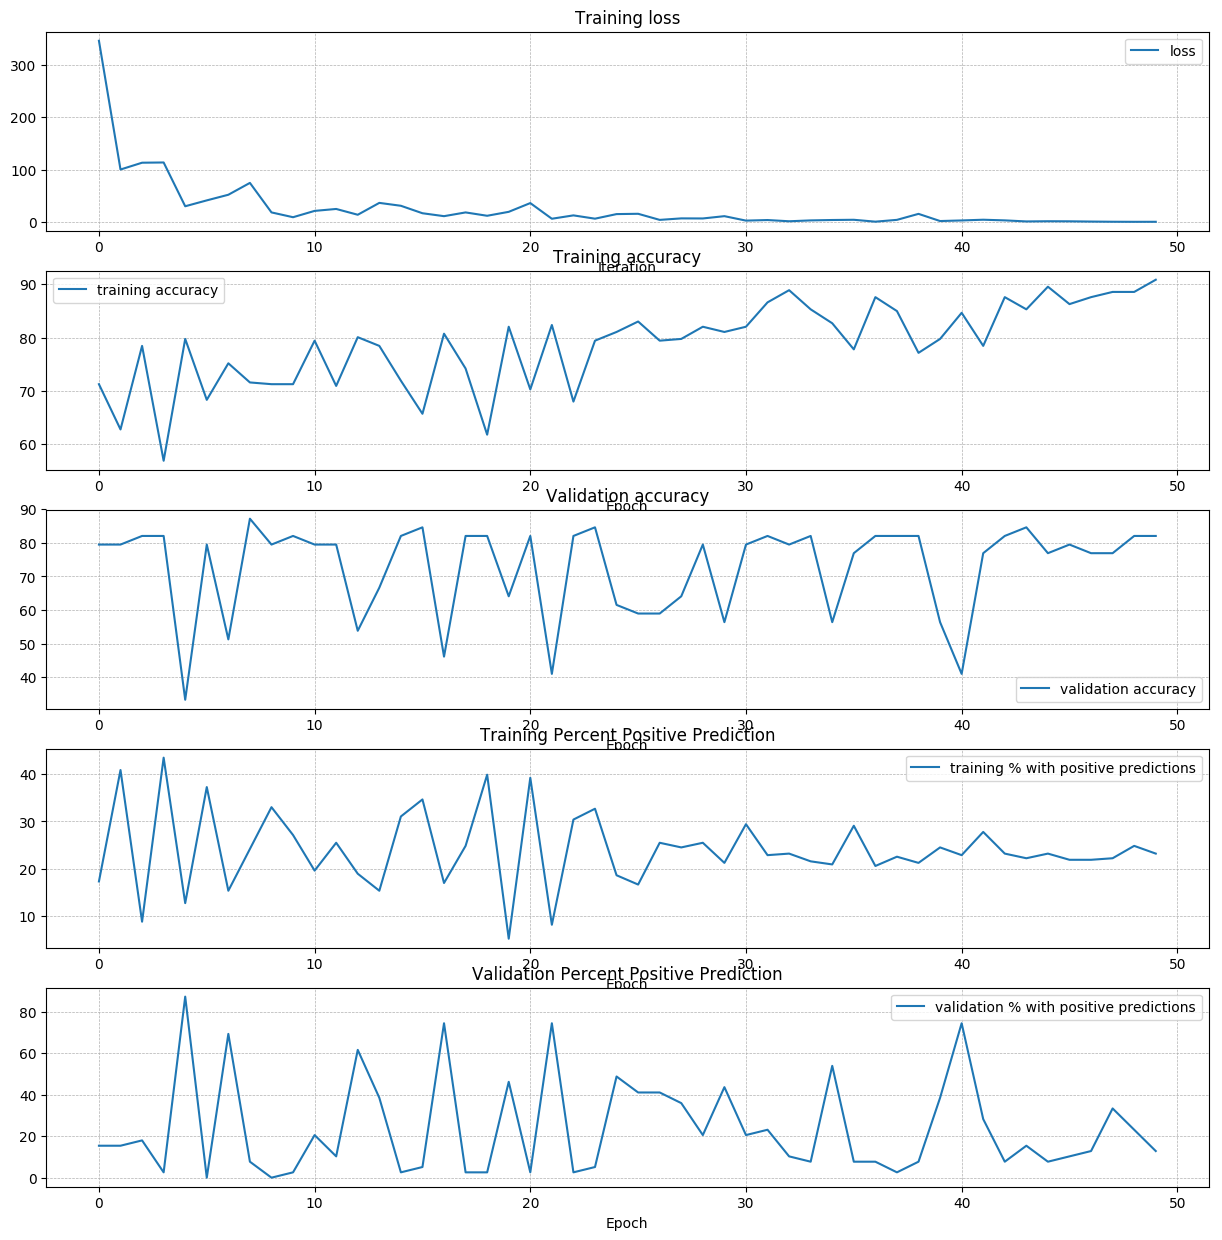

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling, weighted loss

In [24]:
# use weighted loss instead of oversampling 
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 51374
hidden_size = 2000
num_classes = 1

num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50, \
    use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

Epoch 0, loss = 712.6618, train_acc = 38.2353, val_acc = 84.6154, train_pos = 67.3203, val_pos = 5.1282
Epoch 1, loss = 376.9875, train_acc = 61.7647, val_acc = 53.8462, train_pos = 41.8301, val_pos = 61.5385
Epoch 2, loss = 110.1482, train_acc = 64.7059, val_acc = 46.1538, train_pos = 36.9281, val_pos = 74.3590
Epoch 3, loss = 198.9892, train_acc = 59.1503, val_acc = 25.6410, train_pos = 46.4052, val_pos = 94.8718
Epoch 4, loss = 131.4236, train_acc = 65.6863, val_acc = 87.1795, train_pos = 43.1373, val_pos = 12.8205
Epoch 5, loss = 110.0805, train_acc = 68.3007, val_acc = 84.6154, train_pos = 43.7908, val_pos = 10.2564
Epoch 6, loss = 143.3473, train_acc = 65.3595, val_acc = 30.7692, train_pos = 40.8497, val_pos = 89.7436
Epoch 7, loss = 115.7908, train_acc = 60.4575, val_acc = 38.4615, train_pos = 45.7516, val_pos = 71.7949
Epoch 8, loss = 40.4692, train_acc = 66.0131, val_acc = 82.0513, train_pos = 44.1176, val_pos = 7.6923
Epoch 9, loss = 84.9151, train_acc = 69.2810, val_acc = 53

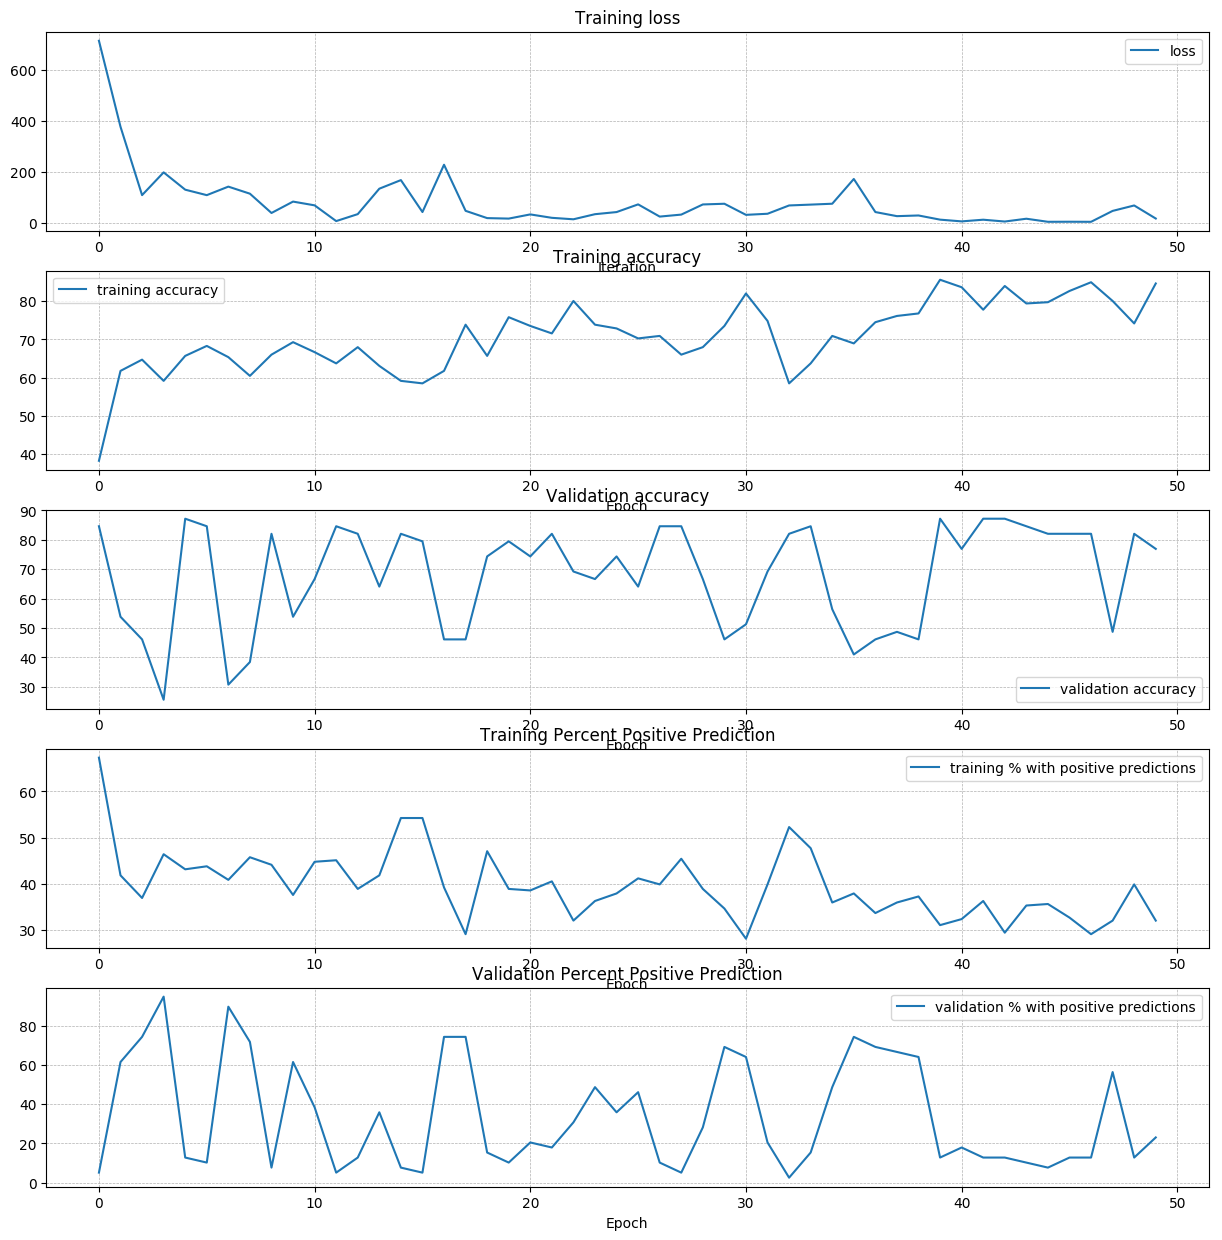

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()